In [26]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Get the csv file, verify it uploaded properly.
column_names = [
    'email',
    'spam',
    'exclamation_marks',
    'flagged_words',
    'question_marks',
]

df = pd.read_csv(
    'emails_with_features.csv',
    header=None,
    names=column_names
)

print(df.head())
print("\nNew column names:", df.columns.tolist())
print(f"Total emails: {len(df)}")
print(f"Spam distribution:\n{df['spam'].value_counts()}")


                                               email  spam  exclamation_marks  \
0  Subject: naturally irresistible your corporate...     1                  0   
1  Subject: the stock trading gunslinger  fanny i...     1                  0   
2  Subject: unbelievable new homes made easy  im ...     1                  0   
3  Subject: 4 color printing special  request add...     1                  2   
4  Subject: do not have money , get software cds ...     1                  1   

   flagged_words  question_marks  
0              0               0  
1              0               0  
2              1               0  
3              0               0  
4              0               1  

New column names: ['email', 'spam', 'exclamation_marks', 'flagged_words', 'question_marks']
Total emails: 5728
Spam distribution:
spam
0    4360
1    1368
Name: count, dtype: int64


In [28]:
# Feature Engineering and Preprocessing

# TF-IDF for text features
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['email']).toarray()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Prepare numerical features
numerical_features = df[['exclamation_marks', 'question_marks', 'flagged_words']].values

# FIX: Scale BOTH TF-IDF and numerical features
scaler_tfidf = StandardScaler()
scaled_tfidf = scaler_tfidf.fit_transform(tfidf_matrix)

scaler_numerical = StandardScaler()
scaled_numerical = scaler_numerical.fit_transform(numerical_features)

# Combine all features (now both are scaled)
X_combined = np.hstack([scaled_tfidf, scaled_numerical])
print(f"Combined feature matrix shape: {X_combined.shape}")

# Dimensionality Reduction (PCA)
# Determine how many components to keep (explain 80% of variance)
pca_full = PCA(random_state=42)
pca_full.fit(X_combined)

# Calculate cumulative explained variance
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= 0.80) + 1

print(f"\nComponents needed to explain 80% variance: {n_components}")
print(f"Variance explained by {n_components} components: {cumsum_variance[n_components - 1]:.3f}")

# Apply PCA with optimal components
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_combined)

print(f"PCA reduced matrix shape: {X_pca.shape}")

TF-IDF matrix shape: (5728, 1000)
Combined feature matrix shape: (5728, 1003)

Components needed to explain 80% variance: 534
Variance explained by 534 components: 0.800
PCA reduced matrix shape: (5728, 534)



--- Evaluating Optimal Number of Clusters ---


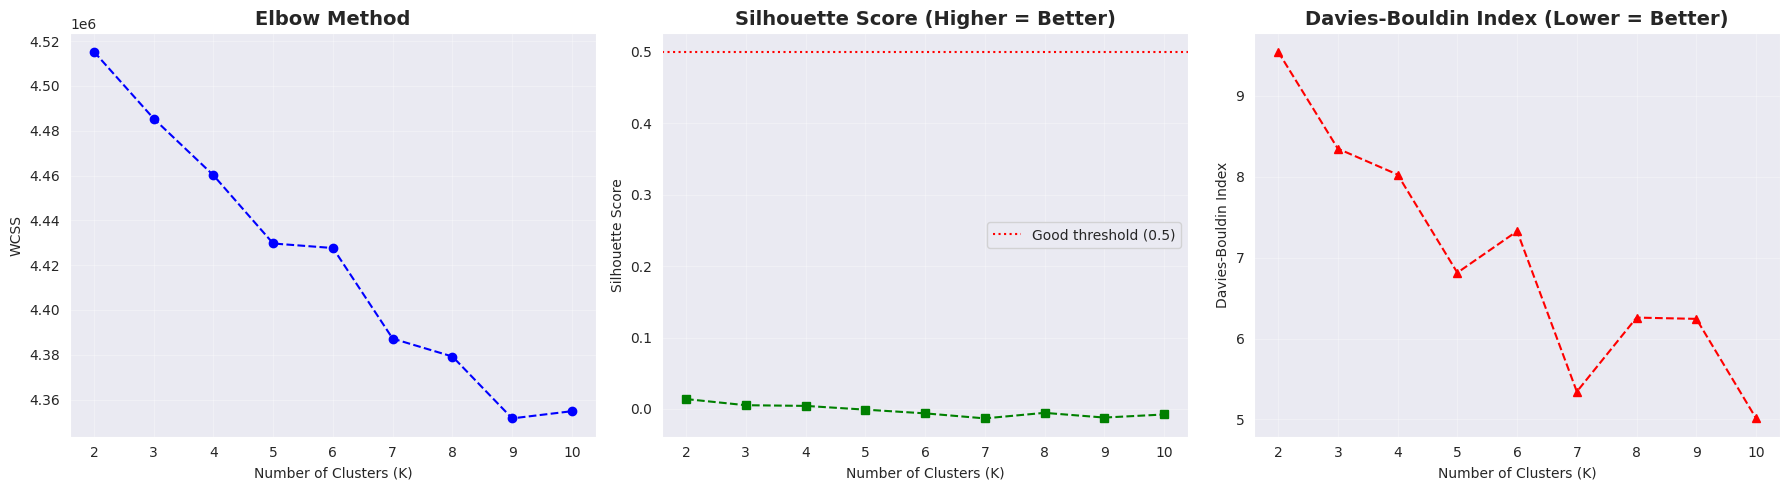


Cluster Quality Metrics:
K	WCSS		Silhouette	Davies-Bouldin
------------------------------------------------------------
2	4515258.93		0.0139		9.5475
3	4485400.48		0.0053		8.3483
4	4460104.31		0.0043		8.0279
5	4429670.70		-0.0009		6.8147
6	4427643.17		-0.0061		7.3279
7	4387224.62		-0.0132		5.3441
8	4379237.59		-0.0054		6.2597
9	4351631.91		-0.0120		6.2439
10	4354843.03		-0.0077		5.0135

📊 Recommendations:
   Best K by Silhouette Score: 2
   Best K by Davies-Bouldin Index: 10


In [29]:
# Determine Optimal Number of Clusters (Multiple Methods)

def evaluate_clusters(data, max_k=10):
    """Evaluate clustering quality using multiple metrics."""
    wcss = []
    silhouette_scores = []
    davies_bouldin_scores = []

    for k in range(2, max_k + 1):  # Start from 2 for silhouette
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300,
                       n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(data)

        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(data, cluster_labels))

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Elbow Method
    axes[0].plot(range(2, max_k + 1), wcss, marker='o', linestyle='--', color='blue')
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Number of Clusters (K)')
    axes[0].set_ylabel('WCSS')
    axes[0].grid(True, alpha=0.3)

    # Silhouette Score (higher is better)
    axes[1].plot(range(2, max_k + 1), silhouette_scores, marker='s',
                linestyle='--', color='green')
    axes[1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Number of Clusters (K)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0.5, color='r', linestyle=':', label='Good threshold (0.5)')
    axes[1].legend()

    # Davies-Bouldin Index (lower is better)
    axes[2].plot(range(2, max_k + 1), davies_bouldin_scores, marker='^',
                linestyle='--', color='red')
    axes[2].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Number of Clusters (K)')
    axes[2].set_ylabel('Davies-Bouldin Index')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\nCluster Quality Metrics:")
    print("K\tWCSS\t\tSilhouette\tDavies-Bouldin")
    print("-" * 60)
    for i, k in enumerate(range(2, max_k + 1)):
        print(f"{k}\t{wcss[i]:.2f}\t\t{silhouette_scores[i]:.4f}\t\t{davies_bouldin_scores[i]:.4f}")

    # Recommendation
    best_silhouette_k = silhouette_scores.index(max(silhouette_scores)) + 2
    best_db_k = davies_bouldin_scores.index(min(davies_bouldin_scores)) + 2

    print(f"\n📊 Recommendations:")
    print(f"   Best K by Silhouette Score: {best_silhouette_k}")
    print(f"   Best K by Davies-Bouldin Index: {best_db_k}")

print("\n--- Evaluating Optimal Number of Clusters ---")
evaluate_clusters(X_pca, max_k=10)



In [31]:
# Perform K-Means Clustering
optimal_k = 2  # Change this if needed based on the metrics
print(f"\n--- Performing K-Means with K={optimal_k} ---")

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300,
                n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels
df['is_spam_original'] = df['spam']

# Calculate final quality metrics
silhouette_avg = silhouette_score(X_pca, cluster_labels)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)

print(f"\nFinal Cluster Quality:")
print(f"  Silhouette Score: {silhouette_avg:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")

# Analyze the Clusters
print("\n" + "=" * 70)
print("📊 CLUSTER ANALYSIS")
print("=" * 70)

# Distribution of spam/non-spam within each cluster
cluster_analysis = df.groupby('cluster')['is_spam_original'].agg(['count', 'sum'])
cluster_analysis.rename(columns={'count': 'Total_Emails', 'sum': 'Spam_Count'}, inplace=True)
cluster_analysis['NonSpam_Count'] = cluster_analysis['Total_Emails'] - cluster_analysis['Spam_Count']
cluster_analysis['Spam_Ratio'] = cluster_analysis['Spam_Count'] / cluster_analysis['Total_Emails']
cluster_analysis['Cluster_Size_%'] = (cluster_analysis['Total_Emails'] / len(df) * 100).round(2)

print("\nCluster Distribution and Spam Ratios:")
print(cluster_analysis.sort_values(by='Spam_Ratio', ascending=False))

# Identify cluster types
print("\n📌 Cluster Characterization:")
for idx in cluster_analysis.index:
    spam_ratio = cluster_analysis.loc[idx, 'Spam_Ratio']
    total = cluster_analysis.loc[idx, 'Total_Emails']

    if spam_ratio >= 0.7:
        cluster_type = "🔴 HIGH SPAM"
    elif spam_ratio >= 0.4:
        cluster_type = "🟡 MIXED"
    else:
        cluster_type = "🟢 MOSTLY LEGITIMATE"

    print(f"Cluster {idx}: {cluster_type} ({spam_ratio:.1%} spam, n={total})")

# Top words per cluster (using original TF-IDF matrix)
print("\n" + "=" * 70)
print("🔤 TOP WORDS PER CLUSTER")
print("=" * 70)


def get_top_words_per_cluster(cluster_labels, tfidf_matrix, feature_names, n_top_words=10):
    """Find most important words for each cluster."""

    for cluster_id in sorted(np.unique(cluster_labels)):
        # Get emails in this cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_tfidf = tfidf_matrix[cluster_mask]

        # Average TF-IDF score for each word in the cluster
        avg_tfidf = cluster_tfidf.mean(axis=0)

        # Get top words
        top_indices = avg_tfidf.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        top_scores = [avg_tfidf[i] for i in top_indices]

        # Print results
        spam_ratio = cluster_analysis.loc[cluster_id, 'Spam_Ratio']
        print(f"\nCluster {cluster_id} (Spam: {spam_ratio:.1%}):")
        for word, score in zip(top_words, top_scores):
            print(f"  • {word:15s} ({score:.4f})")


# Use the ORIGINAL tfidf_matrix (before scaling/PCA)
feature_names = tfidf.get_feature_names_out()
get_top_words_per_cluster(df['cluster'].values, tfidf_matrix, feature_names)

# Analyze numerical features by cluster
print("\n" + "=" * 70)
print("📈 NUMERICAL FEATURES BY CLUSTER")
print("=" * 70)

numerical_analysis = df.groupby('cluster')[['exclamation_marks', 'question_marks',
                                            'flagged_words']].mean()
print("\nAverage values per cluster:")
print(numerical_analysis.round(2))

# Sample emails from each cluster
print("\n" + "=" * 70)
print("📧 SAMPLE EMAILS FROM EACH CLUSTER")
print("=" * 70)

for cluster_id in sorted(df['cluster'].unique()):
    spam_ratio = cluster_analysis.loc[cluster_id, 'Spam_Ratio']
    print(f"\n--- Cluster {cluster_id} (Spam: {spam_ratio:.1%}) ---")

    # Show 2 spam and 2 non-spam examples if available
    cluster_emails = df[df['cluster'] == cluster_id]
    spam_emails = cluster_emails[cluster_emails['is_spam_original'] == 1]
    nonspam_emails = cluster_emails[cluster_emails['is_spam_original'] == 0]

    if len(spam_emails) > 0:
        print("\nSpam examples:")
        for idx, row in spam_emails.head(2).iterrows():
            email_preview = row['email'][:100] + "..." if len(row['email']) > 100 else row['email']
            print(f"  • {email_preview}")

    if len(nonspam_emails) > 0:
        print("\nNon-spam examples:")
        for idx, row in nonspam_emails.head(2).iterrows():
            email_preview = row['email'][:100] + "..." if len(row['email']) > 100 else row['email']
            print(f"  • {email_preview}")

# Save results
columns_to_save = [
    'email',
    'spam',
    'exclamation_marks',
    'question_marks',
    'flagged_words',
    'cluster'
]

df[columns_to_save].to_csv('features_with_clusters.csv', index=False)

print("\n" + "=" * 70)
print("✅ Successfully saved features with cluster IDs to features_with_clusters.csv")
print("=" * 70)

# Save cluster analysis report
with open('cluster_analysis_report.txt', 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("CLUSTER ANALYSIS REPORT\n")
    f.write("=" * 70 + "\n\n")

    f.write(f"Optimal K: {optimal_k}\n")
    f.write(f"Silhouette Score: {silhouette_avg:.4f}\n")
    f.write(f"Davies-Bouldin Index: {davies_bouldin:.4f}\n\n")

    f.write("Cluster Statistics:\n")
    f.write(cluster_analysis.to_string())

    f.write("\n\nNumerical Features by Cluster:\n")
    f.write(numerical_analysis.to_string())

print("✅ Cluster analysis report saved to cluster_analysis_report.txt")


--- Performing K-Means with K=2 ---

Final Cluster Quality:
  Silhouette Score: 0.0139
  Davies-Bouldin Index: 9.5475

📊 CLUSTER ANALYSIS

Cluster Distribution and Spam Ratios:
         Total_Emails  Spam_Count  NonSpam_Count  Spam_Ratio  Cluster_Size_%
cluster                                                                     
0                2774        1360           1414    0.490267           48.43
1                2954           8           2946    0.002708           51.57

📌 Cluster Characterization:
Cluster 0: 🟡 MIXED (49.0% spam, n=2774)
Cluster 1: 🟢 MOSTLY LEGITIMATE (0.3% spam, n=2954)

🔤 TOP WORDS PER CLUSTER

Cluster 0 (Spam: 49.0%):
  • subject         (0.0512)
  • com             (0.0352)
  • new             (0.0276)
  • click           (0.0275)
  • http            (0.0274)
  • business        (0.0266)
  • software        (0.0236)
  • enron           (0.0233)
  • email           (0.0228)
  • information     (0.0224)

Cluster 1 (Spam: 0.3%):
  • ect             (0.1179)